# Introduction

This is a notebook that use the GitHub status to find the oldest PR commit which has a status that contains a linkt to travis-ci.org. We compare this date against the date returned by the Travis API, and conclude that the status date is more accurate.  

In [1]:
from pymongo import MongoClient

mongo_client = MongoClient()

database = mongo_client["graduation"]

pull_requests_collection = database["pull_requests"]

projects_collection = database["projects"]

commits_collection = database["commits"]


In [2]:
from urllib.parse import urlparse
import analysis_utilities

import datetime

scraped_projects = list(projects_collection.find({'succeeded': True, 'travis_is_oldest_ci': {'$exists':False}}))
print("Analyzing {}".format(len(scraped_projects)))

for project in scraped_projects:
    print("-----------------------------------------")
    print("Starting {}".format(project["full_name"]))
    
    pull_requests = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],
                                                       'project_owner': project["full_name"].split("/")[0]}))
    
    sha_list = list([commit for pr in pull_requests for commit in pr["commits"]])
        
    commits = [commits_collection.find_one({'sha': sha_hash}) for sha_hash in sha_list]
    
    statuses = list([status for commit in commits for status in commit["statuses"]])
    
    print("{} commits, and {} statuses".format(len(commits), len(statuses)))
    
    print("Oldest reported status is: {}".format(min([status["created_at"] for status in statuses])))
    
    all_urls = [status["target_url"] for status in statuses]
    
    hostnames = list(set([urlparse(url).hostname for url in all_urls if urlparse(url).hostname is not None]))
    
    print("Total of {} unique hostnames".format(len(hostnames)))
    
    print("Hostnames are: {}".format(", ".join(hostnames)))
    
    travis_statuses = list([status["created_at"] for status in statuses if urlparse(status["target_url"]).hostname == "travis-ci.org"])
    
    if len(travis_statuses) == 0:
        # this is pointless, update and continue
        project["status_travis_date"] = None
        project["travis_is_oldest_ci"] = False
        
        projects_collection.replace_one({"full_name" : project["full_name"]}, project)
        
        continue
    
    oldest_travis_date = min(travis_statuses)
    
    oldest_status_date = min([status["created_at"] for status in statuses])
    
    print("Oldest travis status is: {}, versus the travis reported date: {}. While oldest status date is {}".format(oldest_travis_date, project["first_build_date_travis"], oldest_status_date))
    
    # We not only need the oldest status date for Travis, we also need the date of
    # the first occurence of the TravisBot in all its glory
    
    travis_bot_pr_dates = list([pr ["created_at"] for pr in pull_requests if any([cmmnt for cmmnt in pr["raw_comments"] if cmmnt["user"]["login"] == 'travisbot'])])
    
    if len(travis_bot_pr_dates) == 0:
        travisbot_oldest_date = None
    else:
        travisbot_oldest_date = min(travis_bot_pr_dates)
        
    print("I found an old comment from the travis bot from {}".format(travisbot_oldest_date))
        
    if travisbot_oldest_date is not None:
        oldest_travis_date = min([travisbot_oldest_date, oldest_travis_date])
    
    if not (oldest_travis_date - oldest_status_date).days > 15:
        project["status_travis_date"] = oldest_travis_date
        project["travis_is_oldest_ci"] = True
        
        prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, pull_requests)
    
        print("{} prs before, and {} prs after".format(len(prs_before), len(prs_after)))       
    else:
        project["status_travis_date"] = oldest_travis_date
        project["travis_is_oldest_ci"] = False
        
  
    
    projects_collection.replace_one({"full_name" : project["full_name"]}, project)
    

Analyzing 0


In [3]:
nr_prs_before = []
nr_prs_after = []

projects = list(projects_collection.find({'succeeded' : True, 'travis_is_oldest_ci': True}))

for project in projects:
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]},
                                            {'_id':1, 'created_at': 1}))
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, False, "status_travis_date")
    
    nr_prs_before.append(len(prs_before))
    nr_prs_after.append(len(prs_after))

print([var for var in nr_prs_before if var == 0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


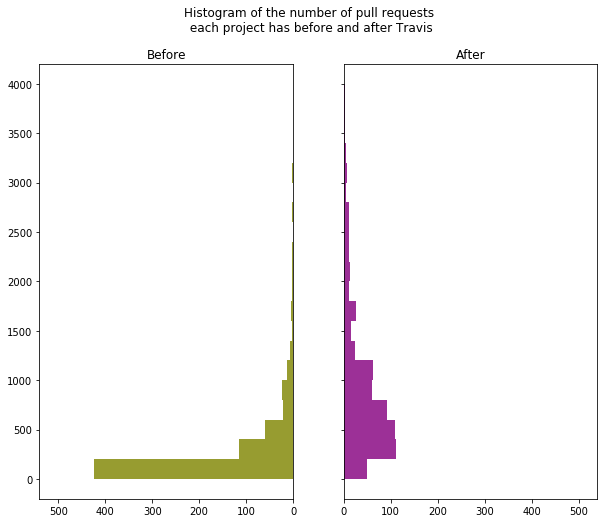

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 8))
axes[0].hist(nr_prs_before, color='#979c30', orientation='horizontal', bins= 20, range=(0, 4000))
axes[0].set_xlim(0, 540)
axes[0].title.set_text("Before")

axes[1].hist(nr_prs_after, color='#9c3097', orientation='horizontal', bins=20, range=(0, 4000), )
axes[1].title.set_text("After")
axes[1].set_xlim(0, 540)

fig.suptitle('Histogram of the number of pull requests\n each project has before and after Travis')

axes[0].invert_xaxis()

plt.show()

In [5]:
nr_prs_before_with_review = []
nr_prs_before_with_effective = []

nr_prs_after_with_review = []
nr_prs_after_with_effective = []

projects = list(projects_collection.find({'succeeded' : True, 'travis_is_oldest_ci': True}))

for project in projects:
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]},
                                            {'_id':1, 'created_at': 1, 'review_comments': 1}))
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, False, "status_travis_date")
    
    nr_prs_after_with_review.append(len([pr for pr in prs_after if len(pr['review_comments']) > 0]))
    nr_prs_after_with_effective.append(len([
        pr for pr in prs_after if len(
            [comment for comment in pr["review_comments"] if 'is_effective' in comment and comment["is_effective"]]
        ) > 0
    ]))
    
    nr_prs_before_with_review.append(len([pr for pr in prs_before if len(pr['review_comments']) > 0]))
    nr_prs_before_with_effective.append(len([
        pr for pr in prs_before if len(
            [comment for comment in pr["review_comments"] if 'is_effective' in comment and comment["is_effective"]]
        ) > 0
    ]))



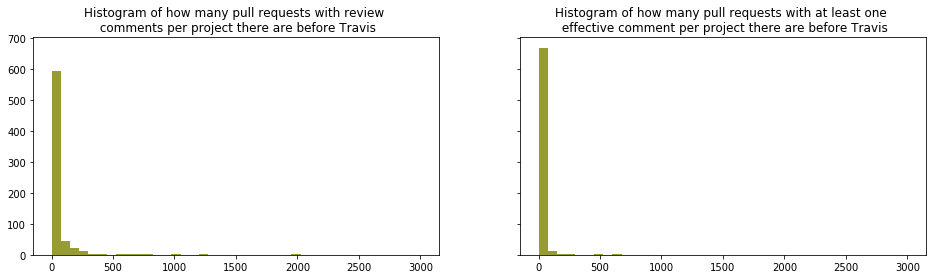

There are 123 projects with no PRs that have a review comment, and 335 projects with no PRs with effective comments


In [6]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(16, 4))
axes[0].hist(nr_prs_before_with_review, color='#979c30', bins= 40, range=(0, 3000))
axes[0].title.set_text("Histogram of how many pull requests with review \n comments per project there are before Travis")

axes[1].hist(nr_prs_before_with_effective, color='#979c30', bins=40, range=(0, 3000), )
axes[1].title.set_text("Histogram of how many pull requests with at least one \n effective comment per project there are before Travis")

plt.show()

print("There are {} projects with no PRs that have a review comment, and {} projects with no PRs with effective comments".format(
len([val for val in nr_prs_before_with_review if val == 0]), len([val for val in nr_prs_before_with_effective if val == 0])))

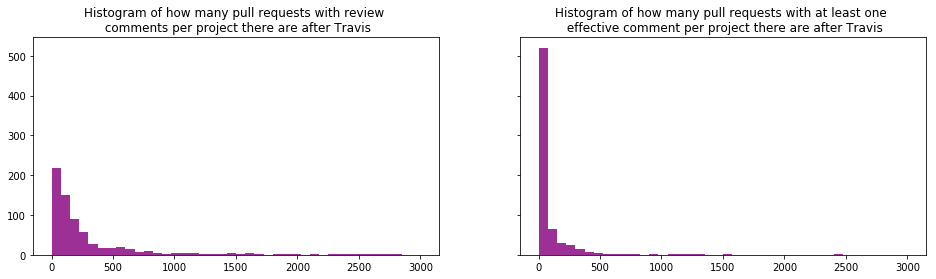

There are 2 projects with no PRs that have a review comment, and 160 projects with no PRs with effective comments


In [7]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(16, 4))
axes[0].hist(nr_prs_after_with_review, color='#9c3097', bins= 40, range=(0, 3000))
axes[0].title.set_text("Histogram of how many pull requests with review \n comments per project there are after Travis")

axes[1].hist(nr_prs_after_with_effective, color='#9c3097', bins=40, range=(0, 3000), )
axes[1].title.set_text("Histogram of how many pull requests with at least one \n effective comment per project there are after Travis")

plt.show()

print("There are {} projects with no PRs that have a review comment, and {} projects with no PRs with effective comments".format(
len([val for val in nr_prs_after_with_review if val == 0]), len([val for val in nr_prs_after_with_effective if val == 0])))

# How do time series look on the dataset?

## First we look at the share of PRs that have atleast one review comment

In [92]:
from datetime import datetime, timedelta

intervention_period = []
before_periods = []
after_periods = []

period_length = 30

for project in projects:
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, False, "status_travis_date", days_delta = period_length/2)
    
               
    travis_date = project["status_travis_date"]
               
    intervention_start = travis_date - timedelta(days=period_length / 2)
    intervention_end = travis_date + timedelta(days=period_length / 2)
    
    intervention_prs = [pr for pr in prs if pr["created_at"] <= intervention_end and pr["created_at"] > intervention_start] 
    
    if len(intervention_prs) > 0:

        share_has_review_comments = len([pr for pr in intervention_prs if len(pr["review_comments"]) > 0]) / len(intervention_prs) if len(intervention_prs) > 0 else 0

        intervention_period.append(share_has_review_comments)
    
    prs_after.sort(key=lambda x: x["created_at"])
    prs_before.sort(key=lambda x: x["created_at"], reverse=True)
                
    def process_prs(prs_todo, target, period_boundaries, next_period):
        index = 0
        period_index = 0

        after_p_end = period_boundaries[1]
        after_p_start = period_boundaries[0]

        prs_in_p = []

        while index < len(prs_todo):
            
            pr = prs_todo[index]

            if pr["created_at"] <= after_p_end and pr["created_at"] > after_p_start:
                prs_in_p.append(pr)

                index += 1

            else:            
                if period_index <= len(target):
                    target.append([])

                if len(prs_in_p) > 0:
                    share_has_review_comments = len([pr for pr in prs_in_p if len(pr["review_comments"]) > 0]) / len(prs_in_p)

                    target[period_index].append(share_has_review_comments)

                after_p_start, after_p_end = next_period((after_p_start, after_p_end)) 
                
                prs_in_p = []

                period_index += 1
                
                
                
        if period_index <= len(target):
            target.append([])

        if len(prs_in_p) > 0:
            share_has_review_comments = len([pr for pr in prs_in_p if len(pr["review_comments"]) > 0]) / len(prs_in_p)

            target[period_index].append(share_has_review_comments)
            
    for_after = lambda pb : (pb[0] + timedelta(days = period_length), pb[1] + timedelta(days = period_length))
    for_before = lambda pb : (pb[0] - timedelta(days = period_length), pb[1] - timedelta(days = period_length))
    
    process_prs(prs_after, after_periods, (intervention_start + timedelta(days = period_length), intervention_end + timedelta(days = period_length)), for_after)
    process_prs(prs_before, before_periods, (intervention_start - timedelta(days = period_length), intervention_end - timedelta(days = period_length)), for_before)

before_periods = list(reversed(before_periods))
               
    

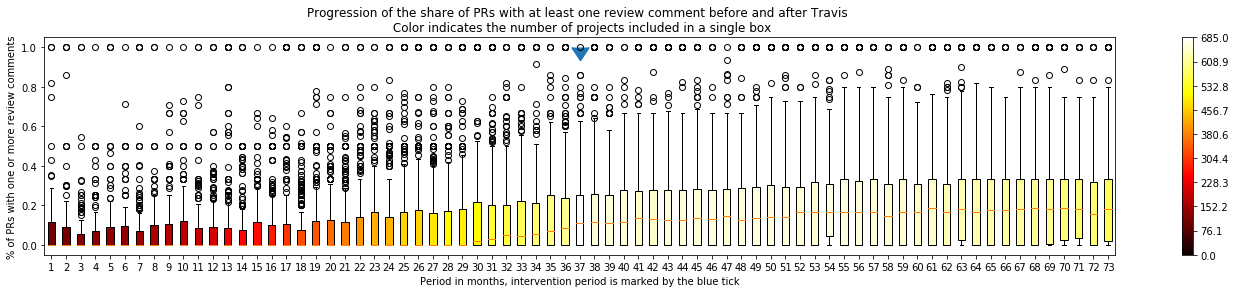

In [91]:
import matplotlib.cm as cm
import numpy as np
import matplotlib as mpl

take_before = 36
take_after = 36

intervention = take_before + 1

data = before_periods[-take_before:] + [intervention_period] + after_periods[:take_after]

plt.figure(figsize=(24,4))

boxplots = plt.boxplot(data, patch_artist=True)

plt.scatter([intervention], [1.0], marker=11, s=[300])

colors = [cm.hot(len(item) / len(projects)) for item in data]

for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)
    
norm = mpl.colors.Normalize(vmin=0,vmax=len(projects))
sm = plt.cm.ScalarMappable(cmap=cm.hot, norm=norm)
sm.set_array(colors)
plt.colorbar(sm, ticks=np.linspace(start = 0, stop = len(projects), num=10))

plt.title("Progression of the share of PRs with at least one review comment before and after Travis \n Color indicates the number of projects included in a single box")
plt.xlabel("Period in months, intervention period is marked by the blue tick")
plt.ylabel("% of PRs with one or more review comments")

plt.show()

## Then we look at the share of PRs that have at least one effective comment

In [94]:
from datetime import datetime, timedelta

intervention_period = []
before_periods = []
after_periods = []

period_length = 30

is_effective = lambda cmnt : 'is_effective' in cmnt and cmnt["is_effective"]

num_of_effective = lambda cmnts : len([cmnt for cmnt in cmnts if is_effective(cmnt)])

for project in projects:
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, False, "status_travis_date", days_delta = period_length/2)
    
               
    travis_date = project["status_travis_date"]
               
    intervention_start = travis_date - timedelta(days=period_length / 2)
    intervention_end = travis_date + timedelta(days=period_length / 2)
    
    intervention_prs = [pr for pr in prs if pr["created_at"] <= intervention_end and pr["created_at"] > intervention_start] 
    
    if len(intervention_prs) > 0:

        share_has_review_comments = len([pr for pr in intervention_prs if num_of_effective(pr["review_comments"]) > 0]) / len(intervention_prs) if len(intervention_prs) > 0 else 0

        intervention_period.append(share_has_review_comments)
    
    prs_after.sort(key=lambda x: x["created_at"])
    prs_before.sort(key=lambda x: x["created_at"], reverse=True)
                
    def process_prs(prs_todo, target, period_boundaries, next_period):
        index = 0
        period_index = 0

        after_p_end = period_boundaries[1]
        after_p_start = period_boundaries[0]

        prs_in_p = []

        while index < len(prs_todo):
            
            pr = prs_todo[index]

            if pr["created_at"] <= after_p_end and pr["created_at"] > after_p_start:
                prs_in_p.append(pr)

                index += 1

            else:            
                if period_index <= len(target):
                    target.append([])

                if len(prs_in_p) > 0:
                    share_has_review_comments = len([pr for pr in prs_in_p if num_of_effective(pr["review_comments"]) > 0]) / len(prs_in_p)

                    target[period_index].append(share_has_review_comments)

                after_p_start, after_p_end = next_period((after_p_start, after_p_end)) 
                
                prs_in_p = []

                period_index += 1
                
                
                
        if period_index <= len(target):
            target.append([])

        if len(prs_in_p) > 0:
            share_has_review_comments = len([pr for pr in prs_in_p if num_of_effective(pr["review_comments"]) > 0]) / len(prs_in_p)

            target[period_index].append(share_has_review_comments)
            
    for_after = lambda pb : (pb[0] + timedelta(days = period_length), pb[1] + timedelta(days = period_length))
    for_before = lambda pb : (pb[0] - timedelta(days = period_length), pb[1] - timedelta(days = period_length))
    
    process_prs(prs_after, after_periods, (intervention_start + timedelta(days = period_length), intervention_end + timedelta(days = period_length)), for_after)
    process_prs(prs_before, before_periods, (intervention_start - timedelta(days = period_length), intervention_end - timedelta(days = period_length)), for_before)

before_periods = list(reversed(before_periods))
               
    

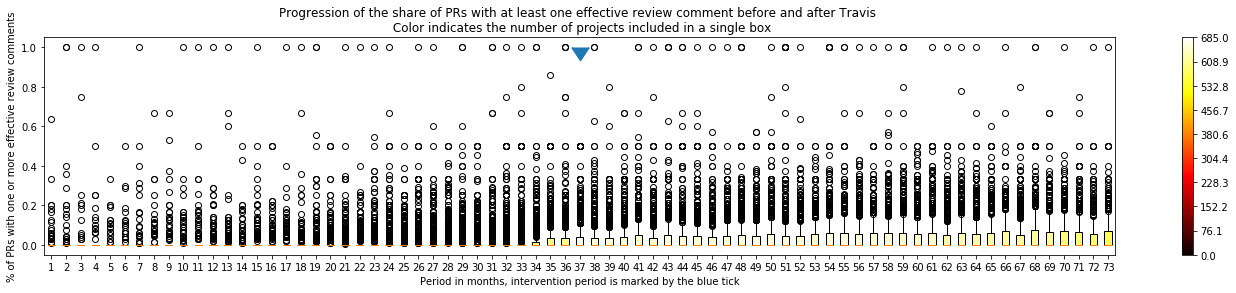

In [95]:
import matplotlib.cm as cm
import numpy as np
import matplotlib as mpl

take_before = 36
take_after = 36

intervention = take_before + 1

data = before_periods[-take_before:] + [intervention_period] + after_periods[:take_after]

plt.figure(figsize=(24,4))

boxplots = plt.boxplot(data, patch_artist=True)

plt.scatter([intervention], [1.0], marker=11, s=[300])

colors = [cm.hot(len(item) / len(projects)) for item in data]

for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)
    
norm = mpl.colors.Normalize(vmin=0,vmax=len(projects))
sm = plt.cm.ScalarMappable(cmap=cm.hot, norm=norm)
sm.set_array(colors)
plt.colorbar(sm, ticks=np.linspace(start = 0, stop = len(projects), num=10))

plt.title("Progression of the share of PRs with at least one effective review comment before and after Travis \n Color indicates the number of projects included in a single box")
plt.xlabel("Period in months, intervention period is marked by the blue tick")
plt.ylabel("% of PRs with one or more effective review comments")

plt.show()

## Finally we look at the share of effective review comments in a certain time period, per project

In [101]:
from datetime import datetime, timedelta

intervention_period = []
before_periods = []
after_periods = []

period_length = 30

is_effective = lambda cmnt : 'is_effective' in cmnt and cmnt["is_effective"]

num_of_effective = lambda cmnts : len([cmnt for cmnt in cmnts if is_effective(cmnt)])

num_of_starter = lambda cmnts : len([cmnt for cmnt in cmnts if cmnt["in_reply_to_id"] is None])

for project in projects:
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, False, "status_travis_date", days_delta = period_length/2)
    
               
    travis_date = project["status_travis_date"]
               
    intervention_start = travis_date - timedelta(days=period_length / 2)
    intervention_end = travis_date + timedelta(days=period_length / 2)
    
    intervention_prs = [pr for pr in prs if pr["created_at"] <= intervention_end and pr["created_at"] > intervention_start] 
    
    if sum([len(pr["review_comments"]) for pr in intervention_prs]) > 0:

        share_has_review_comments = sum([num_of_effective(pr["review_comments"]) for pr in intervention_prs]) / sum([num_of_starter(pr["review_comments"]) for pr in intervention_prs])

        intervention_period.append(share_has_review_comments)
    
    prs_after.sort(key=lambda x: x["created_at"])
    prs_before.sort(key=lambda x: x["created_at"], reverse=True)
                
    def process_prs(prs_todo, target, period_boundaries, next_period):
        index = 0
        period_index = 0

        after_p_end = period_boundaries[1]
        after_p_start = period_boundaries[0]

        prs_in_p = []

        while index < len(prs_todo):
            
            pr = prs_todo[index]

            if pr["created_at"] <= after_p_end and pr["created_at"] > after_p_start:
                prs_in_p.append(pr)

                index += 1

            else:            
                if period_index <= len(target):
                    target.append([])

                if sum([len(pr["review_comments"]) for pr in prs_in_p]) > 0:
                    share_has_review_comments = sum([num_of_effective(pr["review_comments"]) for pr in prs_in_p]) / sum([num_of_starter(pr["review_comments"]) for pr in prs_in_p])

                    target[period_index].append(share_has_review_comments)

                after_p_start, after_p_end = next_period((after_p_start, after_p_end)) 
                
                prs_in_p = []

                period_index += 1
                
                
                
        if period_index <= len(target):
            target.append([])

        if sum([len(pr["review_comments"]) for pr in prs_in_p]) > 0:
            share_has_review_comments = sum([num_of_effective(pr["review_comments"]) for pr in prs_in_p]) / sum([num_of_starter(pr["review_comments"]) for pr in prs_in_p])

            target[period_index].append(share_has_review_comments)
            
    for_after = lambda pb : (pb[0] + timedelta(days = period_length), pb[1] + timedelta(days = period_length))
    for_before = lambda pb : (pb[0] - timedelta(days = period_length), pb[1] - timedelta(days = period_length))
    
    process_prs(prs_after, after_periods, (intervention_start + timedelta(days = period_length), intervention_end + timedelta(days = period_length)), for_after)
    process_prs(prs_before, before_periods, (intervention_start - timedelta(days = period_length), intervention_end - timedelta(days = period_length)), for_before)

before_periods = list(reversed(before_periods))
               
    

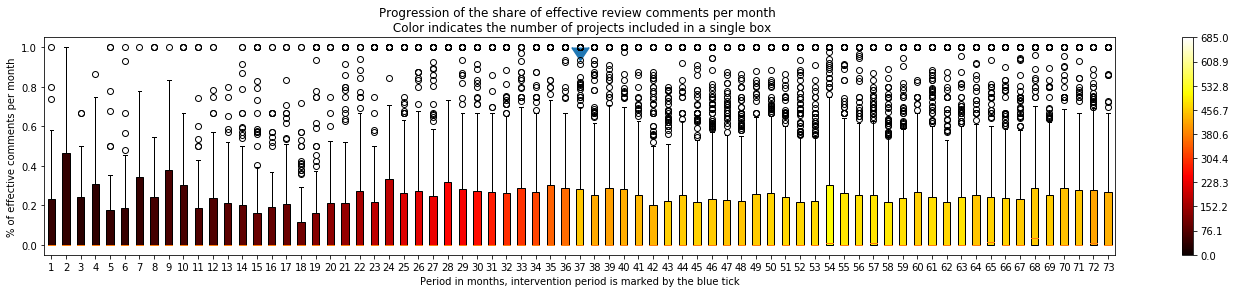

In [102]:
import matplotlib.cm as cm
import numpy as np
import matplotlib as mpl

take_before = 36
take_after = 36

intervention = take_before + 1

data = before_periods[-take_before:] + [intervention_period] + after_periods[:take_after]

plt.figure(figsize=(24,4))

boxplots = plt.boxplot(data, patch_artist=True)

plt.scatter([intervention], [1.0], marker=11, s=[300])

colors = [cm.hot(len(item) / len(projects)) for item in data]

for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)
    
norm = mpl.colors.Normalize(vmin=0,vmax=len(projects))
sm = plt.cm.ScalarMappable(cmap=cm.hot, norm=norm)
sm.set_array(colors)
plt.colorbar(sm, ticks=np.linspace(start = 0, stop = len(projects), num=10))

plt.title("Progression of the share of effective review comments per month \n Color indicates the number of projects included in a single box")
plt.xlabel("Period in months, intervention period is marked by the blue tick")
plt.ylabel("% of effective comments per month")

plt.show()

In [34]:
def do_before_after_boxplot(before_data, after_data, names, title, ylabel, yscale="log"):
    plt.figure(figsize=(15,5))


    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)   

    bpl = plt.boxplot(before_data, positions=np.array(range(len(before_data)))*2.0-0.4, sym='o', widths=0.6)
    bpr = plt.boxplot(after_data, positions=np.array(range(len(after_data)))*2.0+0.4, sym='o', widths=0.6)
    set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#2C7BB6')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='Before CI')
    plt.plot([], c='#2C7BB6', label='After CI')
    plt.legend()

    plt.xticks(range(0, len(names) * 2, 2), names, rotation="vertical")
    plt.xlim(-2, len(names)*2)

    plt.yscale(yscale)

    plt.title(title)
    plt.ylabel(ylabel)

    plt.show()

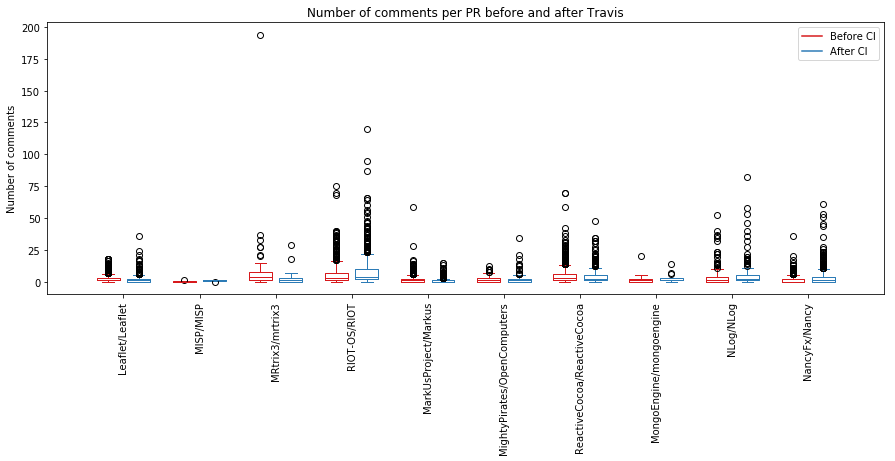

In [35]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

%matplotlib inline
plt.rcParams['savefig.dpi'] = 100 

before_total_comments = []
after_total_comments = []

project_names = []

for project in scraped_projects[:10]:
    
    project_names.append(project["full_name"])
    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)
    
    before_total_comments.append([len(pr["raw_comments"]) for pr in prs_before])
    after_total_comments.append([len(pr["raw_comments"]) for pr in prs_after])

do_before_after_boxplot(before_total_comments, after_total_comments, project_names, 
                       'Number of comments per PR before and after Travis',
                       'Number of comments',
                       yscale='linear')
    


In [36]:
def calculate_time_to_first_comment(prs):
    for pr in prs:
        
        first_comment_time = None
        
        for cmmnt in pr["raw_comments"]:
            cmmnt["is_first_human"] = False
            if cmmnt["user"]["login"]  not in ["coveralls", "codecov-io", "slnode", "pep8speaks", "rh-atomic-bot", "cesium-concierge"] and first_comment_time is None:
                first_comment_time = cmmnt["created_at"]
                cmmnt["is_first_human"] = True
        
        if first_comment_time == None:
            pr["minutes_till_first_comment"] = first_comment_time
            continue
                
        
        pr["minutes_till_first_comment"] = (first_comment_time - pr["created_at"]).total_seconds() / 60.0

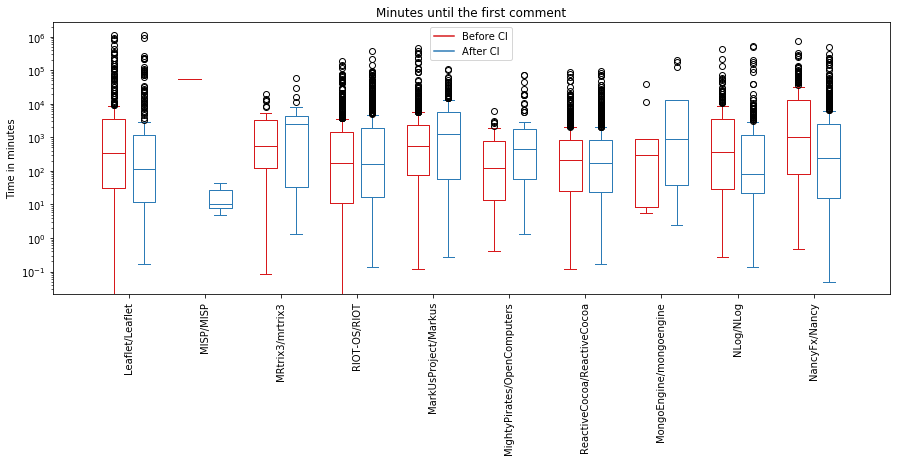

In [37]:
before_time_to_first_comment = []
after_time_to_first_comment = []

project_names = []

for project in scraped_projects[:10]:
    
    project_names.append(project["full_name"])
    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)
    
    calculate_time_to_first_comment(prs_before)
    calculate_time_to_first_comment(prs_after)
    
    before_time_to_first_comment.append([pr["minutes_till_first_comment"] for pr in prs_before if pr["minutes_till_first_comment"] is not None])
    after_time_to_first_comment.append([pr["minutes_till_first_comment"] for pr in prs_after if pr["minutes_till_first_comment"] is not None])

do_before_after_boxplot(before_time_to_first_comment, after_time_to_first_comment, project_names, 
                       'Minutes until the first comment',
                       'Time in minutes')